In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score

sns.set_style("whitegrid")
np.random.seed(0)


MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

from subprocess import check_output
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("train.csv")

In [3]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

753it [00:00, 7524.84it/s]

loading word embeddings...


111052it [00:12, 9039.91it/s]

found 111052 word vectors


num train:  159571


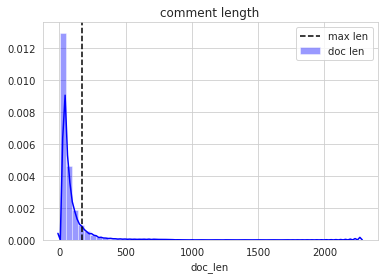

In [4]:
print("num train: ", data.shape[0])

label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

#visualize word distribution
data['doc_len'] = data['comment_text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(data['doc_len'].mean() + data['doc_len'].std()).astype(int)
sns.distplot(data['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [5]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,doc_len
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,42
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,18
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,42
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,112
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,13


In [6]:
X = data[['comment_text']]
y = data[label_names].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [8]:
raw_docs_train = X_train['comment_text'].tolist()
raw_docs_test = X_test['comment_text'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

  1%|          | 1258/111699 [00:00<00:08, 12577.64it/s]

pre-processing train data...


100%|██████████| 47872/47872 [00:01<00:00, 26971.25it/s]


tokenizing input data...
dictionary size:  186531


In [9]:
processed_docs_train

['Conflict interest note By user name appears represent company organization Please read conflict interest guidelines well FAQ businesses We welcome contributions please refrain writing company services personnel Thanks happy editing Speaketh',
 'update actually I changed something blander',
 'MRCA article Sniperz11 thanks comments edits I added part Mirage 2000 original MRCA Indian Air Force article But frankly speaking I think need separate MRCA article Although large another military contract In opinion contracts tenders might deserve separate articles large sections describing Thanks',
 'Arguing BART Caltrain get money virtue fact rail systems may arguing cost effectiveness still valid argument Cost effectiveness end BART AC Transit serve different functions funding levels reflect No bus service could take place BART seems foolish hold funding standards That I meant',
 'Blocked Hi I blocked 24 hours uncivil personal attacks http en wikipedia org w index php title List_of_state name

In [10]:
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [11]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 50604


In [12]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['incontrovertible' 'notrs' 'almanah' '10pitch' 'compacttoc' 'dannenberg'
 'lunarian' 'dissease' 'littlebigplanet' 'kalai']


In [13]:
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 168, 300)          30000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 168, 64)           134464    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 84, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 84, 64)            28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
drop

In [14]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [15]:
#model training
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, 
                 epochs=num_epochs, callbacks=callbacks_list, 
                 validation_split=0.1, shuffle=True, verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 100529 samples, validate on 11170 samples
Epoch 1/8
100529/100529 [==============================] - 312s 3ms/step - loss: 0.1085 - acc: 0.9664 - val_loss: 0.0739 - val_acc: 0.9760
Epoch 2/8
100529/100529 [==============================] - 314s 3ms/step - loss: 0.0690 - acc: 0.9780 - val_loss: 0.0696 - val_acc: 0.9771
Epoch 3/8
100529/100529 [==============================] - 288s 3ms/step - loss: 0.0615 - acc: 0.9798 - val_loss: 0.0638 - val_acc: 0.9784
Epoch 4/8
100529/100529 [==============================] - 287s 3ms/step - loss: 0.0556 - acc: 0.9812 - val_loss: 0.0631 - val_acc: 0.9786
Epoch 5/8
100529/100529 [==============================] - 308s 3ms/step - loss: 0.0511 - acc: 0.9822 - val_loss: 0.0619 - val_acc: 0.9788
Epoch 6/8
100529/100529 [==============================] - 324s 3ms/step - loss: 0.0474 - acc: 0.9832 - val_loss: 0.0619 - val_a

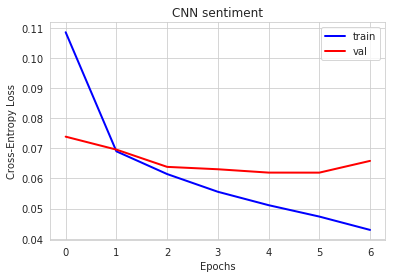

In [16]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

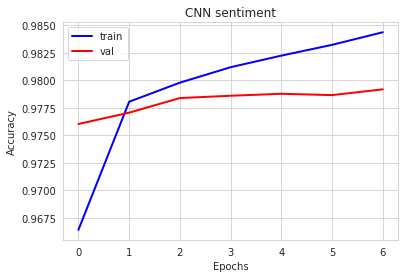

In [17]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [18]:
y_pred = model.predict(word_seq_test)

In [19]:
y_pred

array([[9.8766208e-02, 3.5703182e-04, 6.4947903e-03, 8.1512332e-04,
        9.3523264e-03, 3.5739839e-03],
       [3.4868717e-05, 0.0000000e+00, 1.2814999e-06, 0.0000000e+00,
        4.1723251e-07, 8.9406967e-08],
       [5.5822641e-02, 4.7922134e-05, 2.5003254e-03, 1.2582541e-04,
        3.8850904e-03, 7.3438883e-04],
       ...,
       [3.8027468e-01, 9.6729994e-03, 5.8977067e-02, 1.5484691e-02,
        9.6578330e-02, 3.0245900e-02],
       [1.3923645e-04, 8.9406967e-08, 7.4207783e-06, 1.4901161e-07,
        3.1888485e-06, 3.8743019e-07],
       [3.3917338e-02, 3.4570694e-05, 3.0943453e-03, 3.3676624e-05,
        1.7212331e-03, 1.3586879e-04]], dtype=float32)

In [20]:
p = y_pred.round()

In [24]:
p

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [37]:
for i, j in enumerate(label_names):
    print(j)
    print(confusion_matrix(y_test[:, i], p[:, i]))
    print(f1_score(y_test[:, i], p[:, i]))
    print(accuracy_score(y_test[:, i], p[:, i]))
    print(recall_score(y_test[:, i], p[:, i]))
    print('\n')

toxic
[[42741   549]
 [ 1464  3118]]
0.7559704206570492
0.9579503676470589
0.680488869489306


severe_toxic
[[47354    32]
 [  423    63]]
0.21686746987951805
0.9904954879679144
0.12962962962962962


obscene
[[44989   327]
 [  764  1792]]
0.7666310160427806
0.9772100601604278
0.701095461658842


threat
[[47736     0]
 [  136     0]]
0.0
0.9971590909090909
0.0


insult
[[44978   505]
 [  913  1476]]
0.6755148741418764
0.9703793449197861
0.617831728756802


identity_hate
[[47440     0]
 [  432     0]]
0.0
0.990975935828877
0.0


